In [0]:
import argparse
import logging
import os
import pickle
import random
import shutil

from matplotlib import pyplot as plt

import numpy as np
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tf.enable_v2_behavior()

In [0]:
BATCH_SIZE = 256
TEST_BATCH_SIZE = 1
NUM_IMPORTANCE_SAMPLES = 256 # for test set marginal likelihood estimation
MISSINGNESS_TYPE = 'MNAR' # MCAR or MNAR
MISSINGNESS_COMPLEXITY = 'COMPLEX' # SIMPLE or COMPLEX
MARGINAL_LL_MC_SAMPLES = 100
DATASET = 'MNIST' # MNIST or SVHN
LIKELIHOOD = 'BERNOULLI' # BERNOULLI or LOGISTIC_MIXTURE
# DATASET = 'SVHN' # MNIST or SVHN
# LIKELIHOOD = 'LOGISTIC_MIXTURE' # BERNOULLI or LOGISTIC_MIXTURE
LOGISTIC_MIXTURE_COMPONENTS = 1
if DATASET == 'MNIST':
  Z_DIM = 50
  img_dim = 28
else:
  Z_DIM = 200
  img_dim = 32

VISUALIZE = False # plot reconstructions
VERBOSE = False # print verbose updates after each training epoch

In [0]:
def generate_missingness(dataset, x_mean):
  missingness_block_size = 7
  if DATASET == 'MNIST':
    num_missing_blocks = 8
    mnar_blocks = [[5, 10], [5, 12], [7, 5], [7, 6], [9, 3], [9, 4], [11, 2],
                   [11, 3], [13, 1], [15, 1]]
  else:
    num_missing_blocks = 9
    mnar_blocks = [[5, 12], [7, 5], [7, 6], [9, 3], [9, 4], [11, 2], [11, 3],
                   [13, 2], [15, 1], [17, 1]]
  if MISSINGNESS_TYPE == 'MNAR':
    mnar_blocks = np.random.permutation(mnar_blocks).tolist()

  images = []
  masks = []
  zero_imp_images = []
  mean_imp_images = []
  labels = []
  for example in dataset:
    b = np.ones_like(example['image'], dtype=np.float32)
    label = example['label']
    if MISSINGNESS_TYPE == 'MCAR' and MISSINGNESS_COMPLEXITY == 'SIMPLE':
      for _ in range(num_missing_blocks):
        x = np.random.choice(img_dim)
        y = np.random.choice(img_dim)
        x_min = max(x - missingness_block_size//2, 0)
        x_max = min(x + missingness_block_size//2, img_dim)
        y_min = max(y - missingness_block_size//2, 0)
        y_max = min(y + missingness_block_size//2, img_dim)
        if DATASET == 'MNIST':
          b[x_min:x_max, y_min:y_max] = 0.0
        else:
          b[x_min:x_max, y_min:y_max, :] = 0.0
    elif MISSINGNESS_TYPE == 'MNAR' or MISSINGNESS_COMPLEXITY == 'COMPLEX':
      if MISSINGNESS_TYPE == 'MNAR':
        missingness_block_size, num_missing_blocks = mnar_blocks[int(label)]
      else:
        idx = np.random.choice(len(mnar_blocks))
        missingness_block_size, num_missing_blocks = mnar_blocks[idx]
      
      for _ in range(num_missing_blocks):
        x = missingness_block_size//2 + np.random.choice(
            img_dim - missingness_block_size)
        y = missingness_block_size//2 + np.random.choice(
            img_dim - missingness_block_size)
        x_min = max(x - missingness_block_size//2, 0)
        x_max = min(x + missingness_block_size//2, img_dim)
        y_min = max(y - missingness_block_size//2, 0)
        y_max = min(y + missingness_block_size//2, img_dim)
        if DATASET == 'MNIST':
          b[x_min:x_max, y_min:y_max] = 0.0
        else:
          b[x_min:x_max, y_min:y_max, :] = 0.0
    
    images.append(example['image'])
    masks.append(b)
    zero_imp_images.append(b * example['image'])
    mean_imp_images.append(b * example['image'] + (1.0 - b) * x_mean)
    labels.append(label)
  return tf.data.Dataset.from_tensor_slices(
      {'x': images, 'x_zero_imp': zero_imp_images, 'b': masks,
       'x_mean_imp': mean_imp_images, 'y': labels})

def cast_img(example):
  example['b'] = tf.cast(example['b'], tf.float32)
  max_val = 255.0

  example['x'] = tf.cast(example['x'], tf.float32) / max_val
  example['x_zero_imp'] = tf.cast(example['x_zero_imp'], tf.float32) / max_val
  example['x_mean_imp'] = tf.cast(example['x_mean_imp'], tf.float32) / max_val
  return example

In [0]:
def generate_datasets():
  if DATASET == 'MNIST':
    train_ds = tfds.load('mnist', split='train', shuffle_files=True)
    test_ds = tfds.load('mnist', split='test', shuffle_files=False)
  else:
    train_ds = tfds.load('svhn_cropped', split='train', shuffle_files=True)
    test_ds = tfds.load('svhn_cropped', split='test', shuffle_files=False)

  train_ds = tfds.as_numpy(train_ds)
  train_ds = [example for example in train_ds]
  train_ds, valid_ds = train_test_split(
      train_ds, train_size=50000 if DATASET == 'MNIST' else 63257,
      test_size=10000)

  test_ds = tfds.as_numpy(test_ds)
  test_ds = [example for example in test_ds]

  x_mean = np.mean(np.asarray([example['image'] for example in train_ds]), axis=0)

  train_ds = generate_missingness(train_ds, x_mean)
  valid_ds = generate_missingness(valid_ds, x_mean)
  test_ds = generate_missingness(test_ds, x_mean)

  train_ds = train_ds.map(cast_img).shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
  valid_ds = valid_ds.map(cast_img).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
  test_ds = test_ds.map(cast_img).batch(TEST_BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
  return train_ds, valid_ds, test_ds

train_ds, valid_ds, test_ds = generate_datasets()

In [5]:
# DS SIZES + CLASS COUNTS - SANITY CHECK

for ds in [train_ds, valid_ds, test_ds]:
  res = []
  for example in ds:
    res.append(tf.one_hot(example['y'], 10))
  res = tf.concat(res, 0)
  print(res.shape[0], tf.reduce_mean(res, axis=0))

63257 tf.Tensor(
[0.06756564 0.18886447 0.14505905 0.11608201 0.10166464 0.09358648
 0.07834706 0.07648166 0.06835607 0.06399292], shape=(10,), dtype=float32)
10000 tf.Tensor([0.0674 0.1914 0.1409 0.1154 0.1027 0.0962 0.0771 0.0757 0.0721 0.0611], shape=(10,), dtype=float32)
26032 tf.Tensor(
[0.06699447 0.1958743  0.15938076 0.1107099  0.09691918 0.09157959
 0.07594499 0.07755839 0.06376767 0.06127074], shape=(10,), dtype=float32)


Label: tf.Tensor(9, shape=(), dtype=int32)
Original image


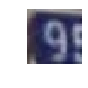

Missingness mask


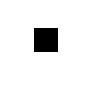

Image with zero imputation


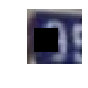

Image with mean imputation


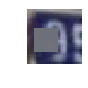

Label: tf.Tensor(9, shape=(), dtype=int32)
Original image


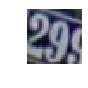

Missingness mask


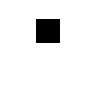

Image with zero imputation


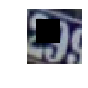

Image with mean imputation


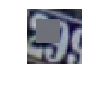

Label: tf.Tensor(4, shape=(), dtype=int32)
Original image


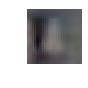

Missingness mask


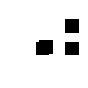

Image with zero imputation


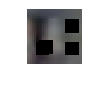

Image with mean imputation


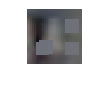

Label: tf.Tensor(3, shape=(), dtype=int32)
Original image


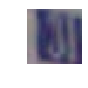

Missingness mask


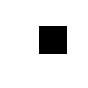

Image with zero imputation


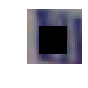

Image with mean imputation


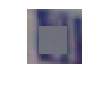

Label: tf.Tensor(5, shape=(), dtype=int32)
Original image


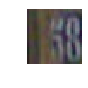

Missingness mask


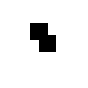

Image with zero imputation


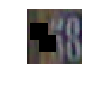

Image with mean imputation


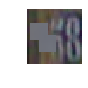

In [6]:
# visualize data

for example in train_ds.take(1):
  for i in range(5):
    print('Label:', example['y'][i])
    if DATASET == 'MNIST':
      print('Original image')
      plt.figure(figsize=(1,1))
      plt.imshow(np.squeeze(example['x'][i]), cmap='gray')
      plt.axis('off')
      plt.show()
      print('Missingness mask')
      plt.figure(figsize=(1,1))
      plt.imshow(np.squeeze(example['b'][i]), cmap='gray')
      plt.axis('off')
      plt.show()
      print('Image with zero imputation')
      plt.figure(figsize=(1,1))
      plt.imshow(np.squeeze(example['x_zero_imp'][i]), cmap='gray')
      plt.axis('off')
      plt.show()
      print('Image with mean imputation')
      plt.figure(figsize=(1,1))
      plt.imshow(np.squeeze(example['x_mean_imp'][i]), cmap='gray')
      plt.axis('off')
      plt.show()
    else:
      print('Original image')
      plt.figure(figsize=(1,1))
      plt.imshow(example['x'][i])
      plt.axis('off')
      plt.show()
      print('Missingness mask')
      plt.figure(figsize=(1,1))
      plt.imshow(example['b'][i])
      plt.axis('off')
      plt.show()
      print('Image with zero imputation')
      plt.figure(figsize=(1,1))
      plt.imshow(example['x_zero_imp'][i])
      plt.axis('off')
      plt.show()
      print('Image with mean imputation')
      plt.figure(figsize=(1,1))
      plt.imshow(example['x_mean_imp'][i])
      plt.axis('off')
      plt.show()

In [0]:
class Encoder(tf.keras.layers.Layer):
  """VAE encoder."""

  def __init__(self, input_shape):
    """Creates an instance of Encoder.

    Returns:
      Encoder instance.
    """
    super(Encoder, self).__init__()

    if DATASET == 'MNIST':
      encoder_layers = [(32, 3, 2), (64, 3, 2)]
    else:
      encoder_layers = [(40, 3, 2), (60, 3, 2), (60, 5, 2)]

    self.conv_layers = []
    for i, (num_filters, kernel_size, strides) in enumerate(encoder_layers):
      if i == 0:
        self.conv_layers.append(tf.keras.layers.Conv2D(
            num_filters, kernel_size, strides=strides, activation=tf.nn.relu,
            data_format='channels_last', input_shape=input_shape,
            padding='SAME'))
      else:
        self.conv_layers.append(tf.keras.layers.Conv2D(
            num_filters, kernel_size, strides=strides, activation=tf.nn.relu,
            data_format='channels_last', padding='SAME'))

    self.mu_proj = tf.keras.layers.Dense(Z_DIM, activation=None)
    self.sigma_proj = tf.keras.layers.Dense(Z_DIM, activation=tf.math.softplus)

  def call(self, x):
    """Computes the forward pass through the Encoder.

    Args:
      x: `Tensor`. 4-D `Tensor` of shape [batch_size, height, width, depth]
        containing the input images.

    Returns:
      A tuple of `Tensors` of shape [batch_size, z_dim] the mean and sigma
      parameters of a Gaussian distribution.
    """
    for layer in self.conv_layers:
      x = layer(x)

    x = tf.keras.layers.Flatten()(x)

    return (self.mu_proj(x), (self.sigma_proj(x) + 1e-3))

class Decoder(tf.keras.layers.Layer):
  """VAE decoder."""

  def __init__(self):
    """Creates an instance of Decoder.

    Returns:
      Decoder instance.
    """
    super(Decoder, self).__init__()

    if DATASET == 'MNIST':
      self.dense = tf.keras.layers.Dense(7*7*20, activation=tf.nn.relu)
      self.reshape_shape = [-1, 7, 7, 20]
      decoder_layers = [(40, 5, 2), (20, 5, 2)]
      fine_tune_layers = [(10, 5, 1), (10, 5, 1)]
      assert LIKELIHOOD == 'BERNOULLI'
      last_layer = (1, 3, 1)
    else:
      self.dense = tf.keras.layers.Dense(4*4*60, activation=tf.nn.relu)
      self.reshape_shape = [-1, 4, 4, 60]
      decoder_layers = [(60, 3, 2), (60, 3, 2), (40, 5, 2)]
      fine_tune_layers = [(30, 5, 1), (30, 5, 1)]
      if LIKELIHOOD == 'LOGISTIC_MIXTURE':
        last_layer = (9 * LOGISTIC_MIXTURE_COMPONENTS, 3, 1)
      else:
        last_layer = (3, 3, 1)

    self.decoder_layers = []
    for i, (num_filters, kernel_size, strides) in enumerate(decoder_layers):
      self.decoder_layers.append(tf.keras.layers.Conv2DTranspose(
          num_filters, kernel_size, strides=strides, activation=tf.nn.relu,
          data_format='channels_last', padding='SAME'))
    
    self.fine_tune_layers = []
    for i, (num_filters, kernel_size, strides) in enumerate(fine_tune_layers):
      self.fine_tune_layers.append(tf.keras.layers.Conv2D(
          num_filters, kernel_size, strides=strides, activation=tf.nn.relu,
          data_format='channels_last', padding='SAME'))
    
    self.last_layer = tf.keras.layers.Conv2D(
          last_layer[0], last_layer[1], strides=last_layer[2],
          activation=None, data_format='channels_last', padding='SAME')

  def call(self, x, b=None):
    """Computes the forward pass through the Decoder.

    Args:
      x: `Tensor`. 4-D `Tensor` of shape [batch_size, height, width, depth]
        containing the input images.

    Returns:
      Tuple of three `Tensors` (mean_logit, scale_logit, pi_logit)
    """
    x = self.dense(x)
    x = tf.reshape(x, self.reshape_shape)
    for layer in self.decoder_layers:
      x = layer(x)

    if b is not None:
      x = tf.concat([x, b], axis=-1)
    
    for layer in self.fine_tune_layers:
      x = layer(x)
    
    x = self.last_layer(x)

    if LIKELIHOOD == 'LOGISTIC_MIXTURE':
      mean_logit = []
      scale_logit = []
      pi_logit = []
      img_channels = 3
      k = LOGISTIC_MIXTURE_COMPONENTS
      for i in range(img_channels):
        mean_logit.append(x[:, :, :, i*k:(i+1)*k])
        scale_logit.append(x[:, :, :,
                             (img_channels*k + i*k):(img_channels*k + (i+1)*k)])
        pi_logit.append(x[:, :, :,
                          (2*img_channels*k + i*k):(2*img_channels*k + (i+1)*k)])
    else:
        mean_logit = x
        scale_logit = None
        pi_logit = None
    
    return mean_logit, scale_logit, pi_logit


class VAE(tf.keras.Model):
  def __init__(self, input_shape):
    super(VAE, self).__init__()
    self.encoder = Encoder(input_shape)
    self.decoder = Decoder()

  def call(self, inputs, decoder_b=None):
    mu, sigma = self.encoder(inputs)
    q_z = tfp.distributions.Normal(mu, sigma)
    
    z_sample = q_z.sample()
    return self.decoder(z_sample, b=decoder_b), q_z, z_sample

In [0]:
def log_sum_exp(x):
  """credit: https://github.com/openai/pixel-cnn/blob/master/pixel_cnn_pp/nn.py"""
  axis = len(x.get_shape())-1
  m = tf.reduce_max(x, axis)
  m2 = tf.reduce_max(x, axis, keepdims=True)
  return m + tf.math.log(tf.reduce_sum(tf.exp(x-m2), axis))

In [0]:
def log_probs(x, b, x_logits, scale_logit, pi_logit):
  if LIKELIHOOD == 'BERNOULLI':
    x_pred = tf.nn.sigmoid(x_logits)
  elif LIKELIHOOD == 'LOGISTIC_MIXTURE':
    img_channels = 3
    scale = [tf.exp(scale_logit[i]) + 1e-2 for i in range(img_channels)]
    pi = [tf.nn.softmax(pi_logit[i], axis=3) for i in range(img_channels)]

    if LOGISTIC_MIXTURE_COMPONENTS == 1:
      x_pred = tf.concat([tf.reduce_sum(x_logits[i], axis=3, keepdims=True)
                          for i in range(img_channels)], axis=3)
    else:
      x_pred = tf.concat(
          [tf.reduce_sum(pi[i] * x_logits[i], axis=3, keepdims=True)
           for i in range(img_channels)], axis=3)

  if LIKELIHOOD == 'BERNOULLI':
    # valid for even real valued MNIST: http://ruishu.io/2018/03/19/bernoulli-vae/
    log_prob_full = -1 * tf.nn.sigmoid_cross_entropy_with_logits(
        labels=x, logits=x_logits)

    log_prob = tf.reduce_sum(b * log_prob_full, axis=[3, 2,1])
    imputation_log_prob = tf.reduce_sum((1.0 - b) * log_prob_full,
                                        axis=[3, 2,1])
  elif LIKELIHOOD == 'LOGISTIC_MIXTURE':
    log_prob_full = []
    for i in range(img_channels):
      x_expanded = tf.concat([tf.expand_dims(x[:, :, :, i], axis=3)
                              for _ in range(LOGISTIC_MIXTURE_COMPONENTS)], axis=3)
      centered_x = x_expanded - x_logits[i]
      upper_in = (centered_x + (1.0/255.0))/scale[i]
      upper_cdf = tf.nn.sigmoid(upper_in)
      lower_in = (centered_x - (1.0/255.0))/scale[i]
      lower_cdf = tf.nn.sigmoid(lower_in)
      cdf_delta = upper_cdf - lower_cdf
      
      mid_in = centered_x/scale[i]
      log_pdf_mid = mid_in - scale_logit[i] - 2.0 * tf.nn.softplus(mid_in)
      log_cdf_plus = upper_in - tf.nn.softplus(upper_in)
      log_one_minus_cdf_min = -tf.nn.softplus(lower_in)
      
      log_prob_comp = tf.where(
          x_expanded < -0.999,
          log_cdf_plus,
          tf.where(x_expanded > 0.999,
                   log_one_minus_cdf_min,
                   tf.where(cdf_delta > 1e-5,
                            tf.math.log(tf.maximum(cdf_delta, 1e-12)),
                            log_pdf_mid - np.log(127.5))))
      if LOGISTIC_MIXTURE_COMPONENTS > 1:
        log_prob_comp += tf.math.log(pi[i])

      log_prob_full.append(log_sum_exp(log_prob_comp))

    log_prob_full = tf.concat([tf.expand_dims(log_prob_full[i], axis=3)
                                for i in range(img_channels)], axis=3)

    log_prob = tf.reduce_sum(b * log_prob_full, axis=[3,2,1])
    imputation_log_prob = tf.reduce_sum((1.0 - b) * log_prob_full, axis=[3,2,1])

  return x_pred, log_prob, imputation_log_prob

In [0]:
def compute_kl(q_z):
  p_z = tfp.distributions.Normal(loc=np.zeros(Z_DIM, dtype=np.float32),
                                 scale=np.ones(Z_DIM, dtype=np.float32))
  return tf.reduce_mean(
      tf.reduce_sum(q_z.kl_divergence(p_z), axis=1))

In [0]:
def loss_fn(q_z, x, b, x_logits, scale_logit, pi_logit):
  x_pred, log_prob, imputation_log_prob = log_probs(
      x, b, x_logits, scale_logit, pi_logit)
  log_prob = tf.reduce_mean(log_prob)
  imputation_log_prob = tf.reduce_mean(imputation_log_prob)
  kl = compute_kl(q_z)
  return (-log_prob + kl, x_pred, log_prob, imputation_log_prob, kl)

In [0]:
def compute_mse(b, x, x_pred):
  sqe = (x - x_pred)**2
  mse_xo = tf.reduce_sum(b * sqe)/tf.reduce_sum(b)
  mse_xm = tf.reduce_sum((1.0 - b) * sqe)/tf.reduce_sum(1.0 - b)
  return mse_xo, mse_xm

In [0]:
def compute_marginal_likelihood_estimate(z_sample, q_z, x, b, x_logits,
                                         scale_logit, pi_logit):
  # importance sampled estimate of the marginal likelihood
  _, log_p_x_given_z, _ = log_probs(x, b, x_logits, scale_logit, pi_logit)

  p_z = tfp.distributions.Normal(loc=np.zeros(Z_DIM, dtype=np.float32),
                                 scale=np.ones(Z_DIM, dtype=np.float32))
  log_p_z = tf.reduce_sum(p_z.log_prob(z_sample), -1)
  log_q_z_given_x = tf.reduce_sum(q_z.log_prob(z_sample), -1)

  log_s = tf.math.log(tf.constant(NUM_IMPORTANCE_SAMPLES, tf.float32))

  marginal_ll = log_sum_exp(log_p_x_given_z + log_p_z - log_q_z_given_x) - log_s

  ln_2 = tf.math.log(tf.constant(2.0, tf.float32))
  num_obs_pixels = tf.reduce_sum(b[0, :, :, 0])
  bits_per_pixel = -(marginal_ll / ln_2) / num_obs_pixels

  return marginal_ll, bits_per_pixel

In [0]:
METHODS = ['Zero Imputation', 'Zero Imputation Encoder Indicators',
           'Zero Imputation Encoder Decoder Indicators']
metrics = {METHOD: {'elbo': [], 'kl': [], 'log_prob': [],
                    'imputation_log_prob': [], 'mse_xo': [], 'mse_xm': [],
                    'marginal_ll': [], 'bits_per_pixel': [], 'accuracy': [],
                    'knn_accuracy': []}
           for METHOD in METHODS}

for run in range(5):
  train_ds, valid_ds, test_ds = generate_datasets()
  for METHOD in METHODS:
    tf.random.set_seed(run)
    np.random.seed(run)
    random.seed(run)

    print(run, METHOD)
    optimizer = tf.keras.optimizers.Adam()

    train_kl_metric = tf.keras.metrics.Mean(name='train_kl')
    train_log_prob_metric = tf.keras.metrics.Mean(name='train_log_prob')
    train_imputation_log_prob_metric = tf.keras.metrics.Mean(
        name='train_imputation_log_prob')
    train_elbo_metric = tf.keras.metrics.Mean(name='train_elbo')
    train_mse_xo_metric = tf.keras.metrics.Mean(name='train_mse_xo')
    train_mse_xm_metric = tf.keras.metrics.Mean(name='train_mse_xm')

    valid_kl_metric = tf.keras.metrics.Mean(name='valid_kl')
    valid_log_prob_metric = tf.keras.metrics.Mean(name='valid_log_prob')
    valid_imputation_log_prob_metric = tf.keras.metrics.Mean(
        name='valid_imputation_log_prob')
    valid_elbo_metric = tf.keras.metrics.Mean(name='valid_elbo')
    valid_mse_xo_metric = tf.keras.metrics.Mean(name='valid_mse_xo')
    valid_mse_xm_metric = tf.keras.metrics.Mean(name='valid_mse_xm')

    test_kl_metric = tf.keras.metrics.Mean(name='test_kl')
    test_log_prob_metric = tf.keras.metrics.Mean(name='test_log_prob')
    test_imputation_log_prob_metric = tf.keras.metrics.Mean(
        name='test_imputation_log_prob')
    test_elbo_metric = tf.keras.metrics.Mean(name='test_elbo')
    test_mse_xo_metric = tf.keras.metrics.Mean(name='test_mse_xo')
    test_mse_xm_metric = tf.keras.metrics.Mean(name='test_mse_xm')
    test_marginal_ll_metric = tf.keras.metrics.Mean(name='test_marginal_ll')
    test_bits_per_pixel_metric = tf.keras.metrics.Mean(
        name='test_bits_per_pixel')

    @tf.function
    def train_step(x, b, inputs, decoder_b, model):
      """Defines a single training step: Update weights based on one batch."""
      with tf.GradientTape() as tape:
        (x_logits, scale_logit, pi_logit), q_z, _ = model(inputs, decoder_b)
        loss_value, x_pred, log_prob, imputation_log_prob, kl = loss_fn(
            q_z, x, b, x_logits, scale_logit, pi_logit)

      grads = tape.gradient(loss_value, model.trainable_weights)
      grads, _ = tf.clip_by_global_norm(grads, 2.5)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

      mse_xo, mse_xm = compute_mse(b, x, x_pred)

      train_kl_metric(kl)
      train_log_prob_metric(log_prob)
      train_imputation_log_prob_metric(imputation_log_prob)
      train_elbo_metric(-loss_value)
      train_mse_xo_metric(mse_xo)
      train_mse_xm_metric(mse_xm)

    @tf.function
    def eval_step(x, b, inputs, decoder_b, model, validation_set=False):
      """Get model predictions for one batch and update metrics."""
      (x_logits, scale_logit, pi_logit), q_z, z_sample = model(
          inputs, decoder_b)
      loss_value, x_pred, log_prob, imputation_log_prob, kl = loss_fn(
          q_z, x, b, x_logits, scale_logit, pi_logit)
      
      mse_xo, mse_xm = compute_mse(b, x, x_pred)

      if validation_set:
        valid_kl_metric(kl)
        valid_log_prob_metric(log_prob)
        valid_imputation_log_prob_metric(imputation_log_prob)
        valid_elbo_metric(-loss_value)
        valid_mse_xo_metric(mse_xo)
        valid_mse_xm_metric(mse_xm)
      else:
        test_kl_metric(kl)
        test_log_prob_metric(log_prob)
        test_imputation_log_prob_metric(imputation_log_prob)
        test_elbo_metric(-loss_value)
        test_mse_xo_metric(mse_xo)
        test_mse_xm_metric(mse_xm)

        marginal_ll, bits_per_pixel = compute_marginal_likelihood_estimate(
            z_sample, q_z, x, b, x_logits, scale_logit, pi_logit)
        test_marginal_ll_metric(marginal_ll)
        test_bits_per_pixel_metric(bits_per_pixel)

    if DATASET == 'MNIST':
      if 'Indicators' in METHOD:
        input_shape = [28, 28, 2]
      else:
        input_shape = [28, 28, 1]
    else:
      if 'Indicators' in METHOD:
        input_shape = [32, 32, 4]
      else:
        input_shape = [32, 32, 3]

    model = VAE(input_shape)

    def get_inputs(example):
      if METHOD == 'Zero Imputation':
        return example['x_zero_imp'], None
      elif METHOD == 'Mean Imputation':
        return example['x_mean_imp'], None
      elif METHOD == 'Zero Imputation Encoder Indicators':
        b = tf.expand_dims(example['b'][:, :, :, 0], -1)
        return tf.concat([example['x_zero_imp'], b], -1), None
      elif METHOD == 'Zero Imputation Encoder Decoder Indicators':
        b = tf.expand_dims(example['b'][:, :, :, 0], -1)
        return tf.concat([example['x_zero_imp'], b], -1), b
        
    best_valid_elbo = None
    num_epochs_since_improvement = 0
    saved_model_loc = 'best_model.h5'
    if os.path.exists(saved_model_loc):
      os.remove(saved_model_loc)

    for epoch in range(200):
      for example in train_ds:
        inputs, decoder_b = get_inputs(example)
        train_step(example['x'], example['b'], inputs, decoder_b, model)

      kl = train_kl_metric.result().numpy()
      log_prob = train_log_prob_metric.result().numpy()
      imputation_log_prob = train_imputation_log_prob_metric.result().numpy()
      elbo = train_elbo_metric.result().numpy()
      mse_xo = train_mse_xo_metric.result().numpy()
      mse_xm = train_mse_xm_metric.result().numpy()

      if VERBOSE:
        print(f'Train set evaluation epoch: {epoch} - '
              f'ELBO: {elbo}, KL: {kl}, log prob: {log_prob}, '
              f'imp log prob: {imputation_log_prob}, '
              f'mse_xo {mse_xo}, mse_xm: {mse_xm}')

      train_kl_metric.reset_states()
      train_log_prob_metric.reset_states()
      train_imputation_log_prob_metric.reset_states()
      train_elbo_metric.reset_states()
      train_mse_xo_metric.reset_states()
      train_mse_xm_metric.reset_states()

      for example in valid_ds:
        inputs, decoder_b = get_inputs(example)
        eval_step(example['x'], example['b'], inputs, decoder_b, model,
                  validation_set=True)

      kl = valid_kl_metric.result().numpy()
      log_prob = valid_log_prob_metric.result().numpy()
      imputation_log_prob = valid_imputation_log_prob_metric.result().numpy()
      elbo = valid_elbo_metric.result().numpy()
      mse_xo = valid_mse_xo_metric.result().numpy()
      mse_xm = valid_mse_xm_metric.result().numpy()

      if VERBOSE:
        print(f'Valid set evaluation epoch: {epoch} - '
              f'ELBO: {elbo}, KL: {kl}, log prob: {log_prob}, '
              f'imp log prob: {imputation_log_prob}, '
              f'mse_xo {mse_xo}, mse_xm: {mse_xm}')

      valid_kl_metric.reset_states()
      valid_log_prob_metric.reset_states()
      valid_imputation_log_prob_metric.reset_states()
      valid_elbo_metric.reset_states()
      valid_mse_xo_metric.reset_states()
      valid_mse_xm_metric.reset_states()

      if best_valid_elbo is None or elbo > best_valid_elbo:
        best_valid_elbo = elbo
        num_epochs_since_improvement = 0
        model.save_weights(saved_model_loc)
      elif num_epochs_since_improvement >= 10:
        break
      else:
        num_epochs_since_improvement += 1

    model.load_weights(saved_model_loc)
    for example in test_ds:
      for k in ['x', 'x_zero_imp', 'b', 'x_mean_imp', 'y']:
        example[k] = tf.repeat(example[k], NUM_IMPORTANCE_SAMPLES, axis=0)
      inputs, decoder_b = get_inputs(example)
      eval_step(example['x'], example['b'], inputs, decoder_b, model,
                validation_set=False)

    kl = test_kl_metric.result().numpy()
    log_prob = test_log_prob_metric.result().numpy()
    imputation_log_prob = test_imputation_log_prob_metric.result().numpy()
    elbo = test_elbo_metric.result().numpy()
    mse_xo = test_mse_xo_metric.result().numpy()
    mse_xm = test_mse_xm_metric.result().numpy()
    marginal_ll = test_marginal_ll_metric.result().numpy()
    bits_per_pixel = test_bits_per_pixel_metric.result().numpy()

    # generate datasets for representation learning
    def gen_rep_learning_datasets(ds):
      z, y = [], []
      for example in ds:
        inputs, decoder_b = get_inputs(example)
        z_mu, _ = model.encoder(inputs)
        z.append(z_mu)
        y.append(example['y'])
      z = tf.concat(z, axis=0).numpy()
      y = tf.concat(y, axis=0).numpy()
      return z, y

    z_train, y_train = gen_rep_learning_datasets(train_ds)
    z_test, y_test = gen_rep_learning_datasets(test_ds)

    # fit logistic classifier
    classifier = LogisticRegression(
        penalty='none', multi_class='multinomial', solver='lbfgs',
        max_iter=1000)
    classifier.fit(z_train, y_train)
    accuracy = classifier.score(z_test, y_test)

    # fit KNN classifier
    classifier = KNeighborsClassifier()
    classifier.fit(z_train, y_train)
    knn_accuracy = classifier.score(z_test, y_test)

    print(f'Test set evaluation epoch: {epoch} - '
          f'bits per pixel: {bits_per_pixel}, marginal ll: {marginal_ll}, '
          f'ELBO: {elbo}, KL: {kl}, log prob: {log_prob}, '
          f'imp log prob: {imputation_log_prob}, '
          f'mse_xo {mse_xo}, mse_xm: {mse_xm}, '
          f'accuracy: {accuracy}, knn accuracy: {knn_accuracy}')
    
    metrics[METHOD]['kl'].append(kl)
    metrics[METHOD]['log_prob'].append(log_prob)
    metrics[METHOD]['imputation_log_prob'].append(imputation_log_prob)
    metrics[METHOD]['elbo'].append(elbo)
    metrics[METHOD]['mse_xo'].append(mse_xo)
    metrics[METHOD]['mse_xm'].append(mse_xm)
    metrics[METHOD]['marginal_ll'].append(marginal_ll)
    metrics[METHOD]['bits_per_pixel'].append(bits_per_pixel)
    metrics[METHOD]['accuracy'].append(accuracy)
    metrics[METHOD]['knn_accuracy'].append(knn_accuracy)

    # visualize data
    if VISUALIZE:
      for example in valid_ds.take(1):
        inputs, decoder_b = get_inputs(example)
        (x_logits, scale_logit, pi_logit), q_z, z_sample = model(
            inputs, decoder_b)
        _, x_pred, _, _, kl = loss_fn(
            q_z, example['x'], example['b'], x_logits, scale_logit, pi_logit)

        for i in range(25):
          print('Label:', example['y'][i])
          if DATASET == 'MNIST':
            print('Original image')
            plt.figure(figsize=(1,1))
            plt.imshow(np.squeeze(example['x'][i]), cmap='gray')
            plt.axis('off')
            plt.show()
            print('Missingness mask')
            plt.figure(figsize=(1,1))
            plt.imshow(np.squeeze(example['b'][i]), cmap='gray')
            plt.axis('off')
            plt.show()
            print('Image with zero imputation')
            plt.figure(figsize=(1,1))
            plt.imshow(np.squeeze(example['x_zero_imp'][i]), cmap='gray')
            plt.axis('off')
            plt.show()
            print('Image with mean imputation')
            plt.figure(figsize=(1,1))
            plt.imshow(np.squeeze(example['x_mean_imp'][i]), cmap='gray')
            plt.axis('off')
            plt.show()
            print('Mean reconstruction')
            plt.figure(figsize=(1,1))
            plt.imshow(np.squeeze(x_pred[i]), cmap='gray')
            plt.axis('off')
            plt.show()
          else:
            print('Original image')
            plt.figure(figsize=(1,1))
            plt.imshow(example['x'][i])
            plt.axis('off')
            plt.show()
            print('Missingness mask')
            plt.figure(figsize=(1,1))
            plt.imshow(example['b'][i])
            plt.axis('off')
            plt.show()
            print('Image with zero imputation')
            plt.figure(figsize=(1,1))
            plt.imshow(example['x_zero_imp'][i])
            plt.axis('off')
            plt.show()
            print('Image with mean imputation')
            plt.figure(figsize=(1,1))
            plt.imshow(example['x_mean_imp'][i])
            plt.axis('off')
            plt.show()
            print('Mean reconstruction')
            plt.figure(figsize=(1,1))
            plt.imshow(x_pred[i])
            plt.axis('off')
            plt.show()

for METHOD in METHODS:
  print('-' * 30)
  print(METHOD)
  print('-' * 30)
  kl = np.mean(metrics[METHOD]['kl'])
  log_prob = np.mean(metrics[METHOD]['log_prob'])
  imputation_log_prob = np.mean(metrics[METHOD]['imputation_log_prob'])
  elbo = np.mean(metrics[METHOD]['elbo'])
  mse_xo = np.mean(metrics[METHOD]['mse_xo'])
  mse_xm = np.mean(metrics[METHOD]['mse_xm'])
  marginal_ll = np.mean(metrics[METHOD]['marginal_ll'])
  bits_per_pixel = np.mean(metrics[METHOD]['bits_per_pixel'])
  accuracy = np.mean(metrics[METHOD]['accuracy'])
  knn_accuracy = np.mean(metrics[METHOD]['knn_accuracy'])
  print(f'Average test set metrics - '
        f'bits per pixel: {bits_per_pixel}, marginal_ll: {marginal_ll}, '
        f'ELBO: {elbo}, KL: {kl}, log prob: {log_prob}, '
        f'imp log prob: {imputation_log_prob}, '
        f'mse_xo {mse_xo}, mse_xm: {mse_xm}, '
        f'accuracy: {accuracy}, knn accuracy: {knn_accuracy}')
  
  for metric in ['imputation_log_prob', 'mse_xo', 'mse_xm', 'marginal_ll',
                 'bits_per_pixel', 'accuracy', 'knn_accuracy']:
    print(metric)
    print(','.join(list(map(str, metrics[METHOD][metric]))))

for metric in ['imputation_log_prob', 'elbo', 'mse_xo', 'mse_xm', 'marginal_ll',
               'bits_per_pixel', 'accuracy', 'knn_accuracy']:
  print('-' * 30)
  print(metric)
  print('-' * 30)
  for METHOD_1 in METHODS:
    for METHOD_2 in METHODS:
      if METHOD_1 != METHOD_2:
        p_value = stats.ttest_rel(
            metrics[METHOD_1][metric], metrics[METHOD_2][metric], axis=0)[1]
        print(f'{METHOD_1} vs. {METHOD_2}: {p_value}')

0 Zero Imputation
Test set evaluation epoch: 84 - bits per pixel: 10.712258338928223, marginal ll: -6046.20849609375, ELBO: -6161.3662109375, KL: 373.7548522949219, log prob: -5787.638671875, imp log prob: -3189.9169921875, mse_xo 0.0006811439525336027, mse_xm: 0.009604786522686481, accuracy: 0.23244468346650277, knn accuracy: 0.37511524277811925
0 Zero Imputation Encoder Indicators
Test set evaluation epoch: 97 - bits per pixel: 10.358136177062988, marginal ll: -5846.37255859375, ELBO: -5948.9482421875, KL: 400.7069091796875, log prob: -5548.251953125, imp log prob: -3478.509521484375, mse_xo 0.0005257061566226184, mse_xm: 0.01001562736928463, accuracy: 0.2107022126613399, knn accuracy: 0.3580977258758451
0 Zero Imputation Encoder Decoder Indicators
Test set evaluation epoch: 148 - bits per pixel: 10.029648780822754, marginal ll: -5661.02392578125, ELBO: -5756.693359375, KL: 433.6149597167969, log prob: -5323.07666015625, imp log prob: -3132.968994140625, mse_xo 0.0004094715986866504,